# 0. Environment Setting

In [152]:
import os
import pandas as pd
import numpy as np
import requests, traceback
from bs4 import BeautifulSoup
import datetime, time
import math
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.mlab as mlab

C:\Users\josep\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\josep\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Get Daily Stock Price from Naver Finance

### Importing Stock Price Data

In [99]:
class get_stock_price:
    def __init__(self, item_name, start, end):
        self.item_name = item_name
        self.start = str(start)
        self.end = str(end)
        
    def get_company_code(self):
        code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0] # 종목코드가 6자리이기 때문에 6자리를 맞춰주기 위해 설정해줌 
        code_df.종목코드 = code_df.종목코드.map('{:06d}'.format) # 우리가 필요한 것은 회사명과 종목코드이기 때문에 필요없는 column들은 제외해준다. 
        code_df = code_df[['회사명', '종목코드']] # 한글로된 컬럼명을 영어로 바꿔준다. 
        code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'})

        company_code = code_df.query("name=='{}'".format(self.item_name))['code'].to_string(index=False)
        company_code =company_code[1:]
        self.company_code = company_code
        return self.company_code
    
    
    def get_last_page(self):
        url = 'http://finance.naver.com/item/sise_day.nhn?code='+ self.company_code
        result = requests.get(url) 
        soup = BeautifulSoup(result.text, 'html.parser')

        maxPage=soup.find_all("table",align="center") 
        lp = maxPage[0].find_all("td",class_="pgRR") 
        last_page = lp[0].a.get('href').rsplit('&')[1]
        last_page = last_page.split('=')[1]
        last_page = int(last_page)
        self.last_page = last_page
        return self.last_page

    def parse_page(self, page):
        try:
            url = 'http://finance.naver.com/item/sise_day.nhn?code=' + self.company_code +'&page='+ str(page)
            result = requests.get(url)
            soup = BeautifulSoup(result.content, 'html.parser')
            df = pd.read_html(str(soup.find("table")), header=0)[0].dropna()   
            return df 
        except Exception as e:
            traceback.print_exc()
        return None
    
    def get_final_df(self):
        final_df = None
        for page in range(1, self.last_page+1):
            _df = self.parse_page(page)
            _df_filtered = _df[_df['날짜'] >= self.start]
            print('Crawling page #{}'.format(page))
            if final_df is None:
                final_df = _df_filtered
            else:
                final_df = pd.concat([final_df, _df_filtered])
                
            if len(_df) > len(_df_filtered) :
                print('Mission Completed')
                break
        
        final_df = final_df.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff',
                                             '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'}) 
        # 데이터의 타입을 int형으로 바꿔줌 
        final_df[['close', 'diff', 'open', 'high', 'low', 'volume']] = final_df[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(int) 
        # 컬럼명 'date'의 타입을 date로 바꿔줌 
        final_df['date'] = pd.to_datetime(final_df['date']) 
        final_df = final_df.sort_values(by=['date'], ascending=True) 
        final_df =  final_df[final_df['date'] <= self.end]
        self.final_df = final_df
        return self.final_df

    def save_to_csv(self):
        path_dir = 'data/{}-crawling'.format(datetime.datetime.strftime(datetime.datetime.today(), '%Y-%m-%d'))
        if not os.path.exists(path_dir):
            os.makedirs(path_dir)
        path = os.path.join(path_dir, '{code}_{start}_{end}.csv'.format(code=self.company_code, start=self.start, end=self.end))
        #save in csv format
        self.final_df.to_csv(path, index=False)
        print('Succesfully Saved in {}'.format(path))


In [101]:
if __name__== "__main__":
     
    item_name = 'SK'
    start = '2019-01-01'
    end = '2019-05-30'
    
    MyStock = get_stock_price(item_name=item_name, start=start, end=end)
    MyStock.get_company_code()
    MyStock.get_last_page()
    MyStock.get_final_df()
    MyStock.save_to_csv()

Crawling page #1
Crawling page #2
Crawling page #3
Crawling page #4
Crawling page #5
Crawling page #6
Crawling page #7
Crawling page #8
Crawling page #9
Crawling page #10
Crawling page #11
Crawling page #12
Crawling page #13
Crawling page #14
Crawling page #15
Mission Completed
Succesfully Saved in data/2019-08-03-crawling\034730_2019-01-01_2019-05-30.csv


# Single Asset Monte-Carlo Simulation

In [176]:
class monte_carlo:
    def __init__(self, start, end):
        self.start = start
        self.end = end

    def get_asset(self):
        df = pd.read_csv('data/2019-08-03-crawling/034730_2019-01-01_2019-05-30.csv')
        close = df['close']
        returns = close.pct_change()
        
        self.returns = returns
        self.prices = close
        
    def monte_carlo_simulation(self, num_simulation, predicted_days):
        returns = self.returns
        prices = self.prices
        
        last_price = prices.iloc[-1]
        simulation_df = pd.DataFrame()
        
        #Create each simulation as a column in df
        for x in range(num_simulation):
            count = 0 
            daily_vol = returns.std()
            
            prices_series = []
            
            #Append start value
            price = last_price * (1 + np.random.normal(0, daily_vol))
            prices_series.append(price)
            
            #Series for predicted days
            for i in range(predicted_days):
                if count == 251:
                    break
                price = prices_series[count] * (1 + np.random.normal(0, daily_vol))
                prices_series.append(price)
                count += 1
            
            simulation_df[x] = prices_series
            self.simulation_df = simulation_df
            self.predicted_days = predicted_days

    def line_graph(self):
        prices = self.prices
        predicted_days = self.predicted_days
        simulation_df = self.simulation_df
        
        last_price = prices.iloc[-1]
        fig = plt.figure(figsize=(16,8))
        style.use('bmh')
        
        title = "Monte Carlo Simulation: " + str(predicted_days) + " Days"
        plt.plot(simulation_df)
        fig.suptitle(title,fontsize=18, fontweight='bold')
        plt.xlabel('Day')
        plt.ylabel('Price (\KRW)')
        plt.annotate('Current Price: {}'.format(last_price), xy=(0, 1), xytext=(20, -20), va='top',
                     xycoords='axes fraction', textcoords='offset points')
        plt.grid(True,color='grey')
        plt.axhline(y=last_price, color='r', linestyle='-')
        plt.show()
        
    def histogram(self):
        simulation_df = self.simulation_df
        
        ser = simulation_df.iloc[-1, :]
        x = ser
        mu = ser.mean()
        sigma = ser.std()
        
        num_bins = 30
        # the histogram of the data
        n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='blue', alpha=0.5)
         
        # add a 'best fit' line
        y = mlab.normpdf(bins, mu, sigma)
        plt.plot(bins, y, 'r--')
        plt.xlabel('Price')
        plt.ylabel('Probability')
        plt.title(r'Histogram of Speculated Stock Prices', fontsize=18, fontweight='bold')
 
        # Tweak spacing to prevent clipping of ylabel
        plt.subplots_adjust(left=0.15)
        plt.show()
        
    
    def VaR(self):
        simulation_df = self.simulation_df
        prices = self.prices

        last_price = prices.iloc[-1]
        
        price_array = simulation_df.iloc[-1, :]
        price_array = sorted(price_array, key=int)  
        var =  np.percentile(price_array, 1)
        
        val_at_risk = last_price - var
        print('Value at Risk: ', val_at_risk)
        
        #Histogram
        fit = stats.norm.pdf(price_array, np.mean(price_array), np.std(price_array))
        plt.plot(price_array,fit,'-o')
        plt.hist(price_array,normed=True)
        plt.xlabel('Price')
        plt.ylabel('Probability')
        plt.title(r'Histogram of Speculated Stock Prices', fontsize=18, fontweight='bold')
        plt.axvline(x=var, color='r', linestyle='--', label='Price at Confidence Interval: ' + str(round(var, 2)))
        plt.axvline(x=last_price, color='k', linestyle='--', label = 'Current Stock Price: ' + str(round(last_price, 2)))
        plt.legend(loc="upper right")
        plt.show()


    def key_stats(self):
        simulation_df = self.simulation_df

        print('#------------------Simulation Stats------------------#')
        count = 1
        for column in simulation_df:
            print("Simulation", count, "Mean Price: ", simulation_df[column].mean())
            print("Simulation", count, "Median Price: ", simulation_df[column].median() )
            count += 1
        
        print('\n')
        
        print('#----------------------Last Price Stats--------------------#')
        print("Mean Price: ", np.mean(simulation_df.iloc[-1,:]))
        print("Maximum Price: ",np.max(simulation_df.iloc[-1,:]))
        print("Minimum Price: ", np.min(simulation_df.iloc[-1,:]))
        print("Standard Deviation: ",np.std(simulation_df.iloc[-1,:]))

        print('\n')
       
        print('#----------------------Descriptive Stats-------------------#')
        price_array = simulation_df.iloc[-1, :]
        print(price_array.describe())
        print('\n')
               
        print('#--------------Annual Expected Returns for Trials-----------#')
        count = 1
        future_returns = simulation_df.pct_change()
        for column in future_returns:
            print("Simulation", count, "Annual Expected Return", "{0:.2f}%".format((future_returns[column].mean() * 252) * 100))
            print("Simulation", count, "Total Return", "{0:.2f}%".format((future_returns[column].iloc[1] / future_returns[column].iloc[-1] - 1) * 100))
            count += 1     

        print('\n')
                         
        #Create Column For Average Daily Price Across All Trials
        simulation_df['Average'] = simulation_df.mean(axis=1)
        ser = simulation_df['Average']
        
        print('#----------------------Percentiles--------------------------------#')
        percentile_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
        for per in percentile_list:
            print("{}th Percentile: ".format(per), np.percentile(price_array, per))
        
        print('\n')

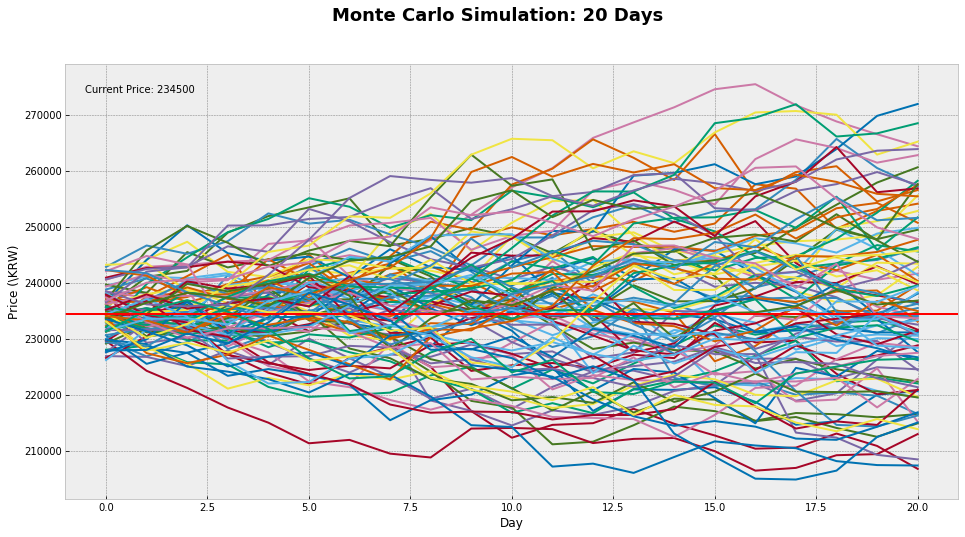

C:\Users\josep\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\josep\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


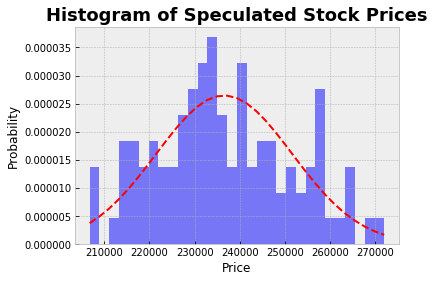

Value at Risk:  27146.113808235736


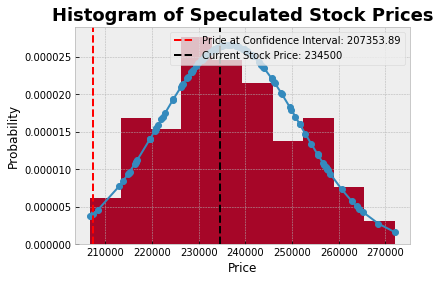

In [179]:

if __name__== "__main__":

    start = datetime.datetime(2019, 1, 1)
    end = datetime.datetime(2019, 6, 1)
    
    sim = monte_carlo(start=start, end=end)

    sim.get_asset()
    sim.monte_carlo_simulation(1000, 200)
    sim.line_graph()
    sim.histogram()
    sim.VaR()
    sim.key_stats()


<strong><u> Reference </u></strong>
* Naver Finance Web Crawling:http://blog.quantylab.com/crawling_naverfin_daycandle.html
* Monte Carlo Simulation using Python:  https://programmingforfinance.com/2017/11/monte-carlo-simulations-of-future-stock-prices-in-python/